In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import itertools

import warnings
warnings.filterwarnings('ignore')

# <center>Deep Generative Models</center>
## <center>Seminar 1</center>

<center>10.09.2024</center>


### Kondratenko Vladimir


tg: @username27

e-mail: vladimir.kondratenko@phystech.edu

## Plan

Part 1
- Maximum Likelihood Estimation
- Histograms
- Bayes' theorem

Part 2
- PixelCNN

## Maximum Likelihood Estimation (MLE)

Recall the general task of Generative Modeling. 

We have samples $X \sim \pi(x)$. We assume, that $\pi(x) = p(x|\theta), \theta \in \Theta$.

We want to estimate $\hat{\theta} = \hat{\theta}(X)$ in order to sample from $p(x|\hat{\theta})$ and estimate the corresponding pdf. 

How?

$\theta^* = \arg\max\limits_{\theta} p(X | \theta) = \arg\max\limits_{\theta} \prod_{i=1}^n p(x_i | \theta) = \arg\max\limits_{\theta} \sum_{i=1}^n \log p(x_i | \theta)$

## MLE examlpes

### Problem 1

$x_1, ... x_n \sim U[0,\theta]$. 

$\hat{\theta}_{ML} = ?$

For a single $x \sim U[0,\theta]$:

$p(x) = \dfrac{1}{\theta}, x \in [0,\theta]$

$p(x) = 0, x \notin [0,\theta]$

We have $x_1, \dots x_n \sim U[0,\theta]$:

$p(X | \theta) = \begin{cases} \dfrac{1}{\theta^{n}}, &X \in [0,\theta]^{n}, \\ 0, &X \notin [0,\theta]^{n} \end{cases}$

It also can be written as:

$p(X | \theta) = \begin{cases} 0, &\theta < \max(x_1, \dots x_n), \\
\dfrac{1}{\theta^{n}}, &\theta \geq \max(x_1, \dots x_n) \end{cases}$

So, we can find:

$\hat{\theta}_{ML} = \max(x_1, ... x_n)$

$\hat{\theta}_{ML} = \max(x_1, ... x_n)$ is also random variable

How does Cumulative distribution function $F_{\hat{\theta}_{ML}}(x) = P(\hat{\theta}_{ML} < x )$ looks like?


$P_{X \sim U[0,\theta]}(\max(x_1, ... x_n) < x) = \dfrac{x^n}{\theta^n}$, $x \in [0,\theta]$

Check if the $\hat{\theta}_{ML}$ is **unbiased** estimation of $\theta$, i.e. $\mathbb{E}\hat{\theta}_{ML} = \theta$.

Let's find this $\mathbb{E}\hat{\theta}_{ML} = ?$

We know that:

$\mathbb{E}x = \int_{-\infty}^{+\infty} x f(x) dx = \int_{-\infty}^{+\infty} x dF(x)$

$\mathbb{E}_{X \sim U[0, \theta]} \hat{\theta}_{ML} = \mathbb{E}_{\hat{\theta}_{ML}} x$

$\mathbb{E}_{X \sim U[0,\theta]}\hat{\theta}_{ML} =
\int_{0}^{\theta} x d \dfrac{x^n}{\theta^n} = ...
%\int_{0}^{\theta} \dfrac{xnx^{n-1}}{\theta^n} d x =
%\int_{0}^{\theta} \dfrac{nx^{n}}{\theta^n} d x =
%\dfrac{n\theta^{n+1}}{(n+1)\theta^n}$

$\Rightarrow \mathbb{E}_{X \sim U[0,\theta]}\hat{\theta}_{ML} = \dfrac{n}{n+1}\theta \Rightarrow$ MLE is **biased**

### MLE

- not unbiased
- *(regularity conditions)* consistent (состоятельные) i.e. $P_{\theta_{\text{true}}}( \Vert \hat{\theta} - \theta_{\text{true}} \Vert > \varepsilon ) \rightarrow 0 \quad \forall \varepsilon > 0$
- *(regularity conditions ++)* asymptotically normal (асимптотически нормальные) i.e $\sqrt{n} \left(\hat{\theta} - \theta \right) \overset{d_{\theta}}{\rightarrow} \mathcal{N}(0, \Sigma(\theta))$
- *(regularity conditions ++)* asymptotically efficient (асимптотически эффективные) i.e. $\sqrt{n} \left(\hat{\theta} - \theta \right) \overset{d_{\theta}}{\rightarrow} \mathcal{N}(0, I(\theta)) \text{  ,where } I(\theta) \text{ is Fisher matrix}$

## Simple distributions
### Example 1

Let we have samples $X \sim \pi(x)$ and want approximate $\pi(x)$

In [2]:
def generate_1d_data(count, bins):
    np.random.seed(42)
    a = 0.2 + 0.05 * np.random.randn(count)
    b = 0.6 + 0.15 * np.random.randn(count)
    mask = np.random.rand(count) < 0.5
    samples = np.clip((a * mask + b * (1 - mask)) * (bins - 1), 0.0, (bins - 1))
    data = samples.astype('int')
    split = int(0.8 * count)
    train_samples, test_samples = samples[:split], samples[split:]
    train_hist, test_hist = data[:split], data[split:]
    return train_samples, test_samples, train_hist, test_hist

In [3]:
def plot_1d_data(train_data, test_data):
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('train')
    ax1.hist(train_data, bins=bins, density=True)
    ax1.set_xlabel('x')
    ax2.set_title('test')
    ax2.hist(test_data, bins=np.arange(bins), density=True)
    plt.show()

Let we have samples $X \sim \pi(x)$ and want approximate $\pi(x)$

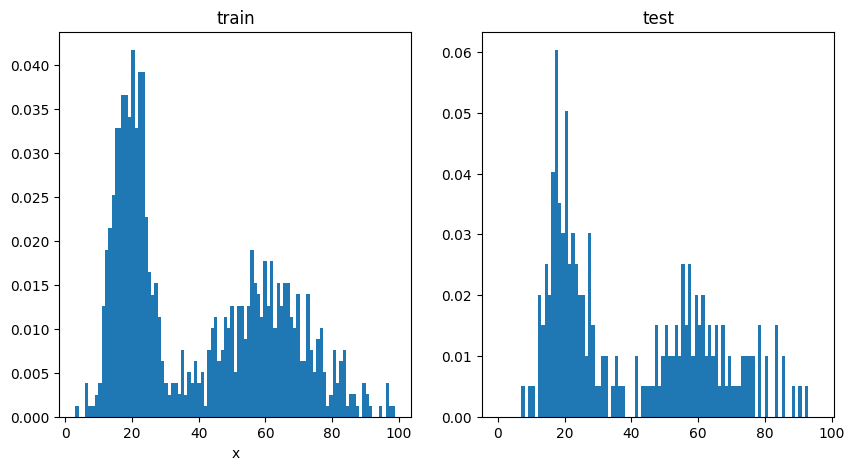

In [4]:
BINS = 100
COUNT = 1000

_, _, train_data, test_data = generate_1d_data(COUNT, BINS)
plot_1d_data(train_data, test_data)

How we can do it?

## MLE and histogram

Let $X_1, X_2, \dots X_N \sim \text{Categorical}(\theta_1, \theta_2, \dots \theta_K)$ , where $\sum\limits_{i = 1}^{K} \theta_i = 1$. Denote $\boldsymbol{\theta} = (\theta_1, \dots, \theta_K)$

**Problem 2**: Find the MLE estimator $\hat{\boldsymbol{\theta}}$

Let $X$ has $n_i$ elements equal to $i$, $\sum\limits_{i=1}^{K}n_i = N$. Loglikelihood: 

$\log p(X|\theta) =\sum\limits_{i=1}^{K} n_i \log p(k=i|\theta)$

**Take a deep breath and work on this step by step**

## Deriving MLE Step-by-Step

To find the MLE, we need to maximize the log-likelihood with respect to $\theta_i$, given the constraint $\sum\limits_{i=1}^{K} \theta_i = 1$.

Define the Lagrangian function:

$$
L(\theta, \lambda) = \sum\limits_{i=1}^{K} n_i \log \theta_i + \lambda \left( \sum\limits_{i=1}^{K} \theta_i - 1 \right)
$$

Take the derivative with respect to $\theta_i$:

$$
\frac{\partial L}{\partial \theta_i} = \frac{n_i}{\theta_i} + \lambda = 0
$$

Solve for $\theta_i$:

$$
\theta_i = -\frac{n_i}{\lambda}
$$

## Applying the Constraint

We know that $\sum\limits_{i=1}^{K} \theta_i = 1$, so we substitute:

$$
\sum\limits_{i=1}^{K} \left(-\frac{n_i}{\lambda}\right) = 1
$$

Simplifying gives:

$$
-\frac{N}{\lambda} = 1 \implies \lambda = -N
$$

Substitute $\lambda$ back to find $\theta_i$:

$$
\theta_i = \frac{n_i}{N}
$$

### Histogram

$\hat{\theta_k} = \dfrac{1}{N} \sum\limits_{j = 1}^{N} I(X_j = k) = \dfrac{n_i}{N}$

## Histogram

$$\hat{\theta_k} = \dfrac{1}{N} \sum\limits_{j = 1}^{N} I(X_j = k) = \dfrac{n_i}{N}$$

## Random fact

How can we avoid using the Lagrange multiplier method? 

For example $ p(k|\theta) = \theta = \dfrac{e^{\theta'_k}}{\sum\limits_{i=1}^{K}e^{\theta'_i}}$ aka **Softmax function**


## Random fact 2

Let $X$ has $n_i$ elements equal to $i$, $\sum\limits_{i=1}^{K}n_i = N$. Loglikelihood: 

$$\log p(X|\theta) =\sum\limits_{i=1}^{K} n_i \log p(k=i|\theta) = \sum\limits_{j = 1}^{N} \sum\limits_{i = 1}^{K}I(X_j = i) \log p(k=i|\theta) = \sum\limits_{j = 1}^{N} \sum\limits_{i = 1}^{K} I(X_j = i) \log p_{j}^{i}$$

Do you know something like that in PyTorch?

**Classic ML setup**

For batch of $\{X_j\}_{j=1}^{N}$ elements and predicted probabilities $\{(p^1_j, \dots , p^K_j)\}_{j=1}^{N}$:

$$\text{CrossEntropyLoss} = - \sum\limits_{j=1}^{N} x_j \log p_{j}^{x_j} = - \sum\limits_{j = 1}^{N} \sum\limits_{i = 1}^{K}I(X_j = i) \log p_{j}^{i}$$


Optimizing **CrossEntropyLoss is equivalent to the MLE estimator** for categorical data

## Histogram in 2D

**Question.** Can we consider binarized MNIST to be sampled from a Categorical distribution?

<!-- <center><img src="data:image/png;base64," width=1200 /></center> -->
<center>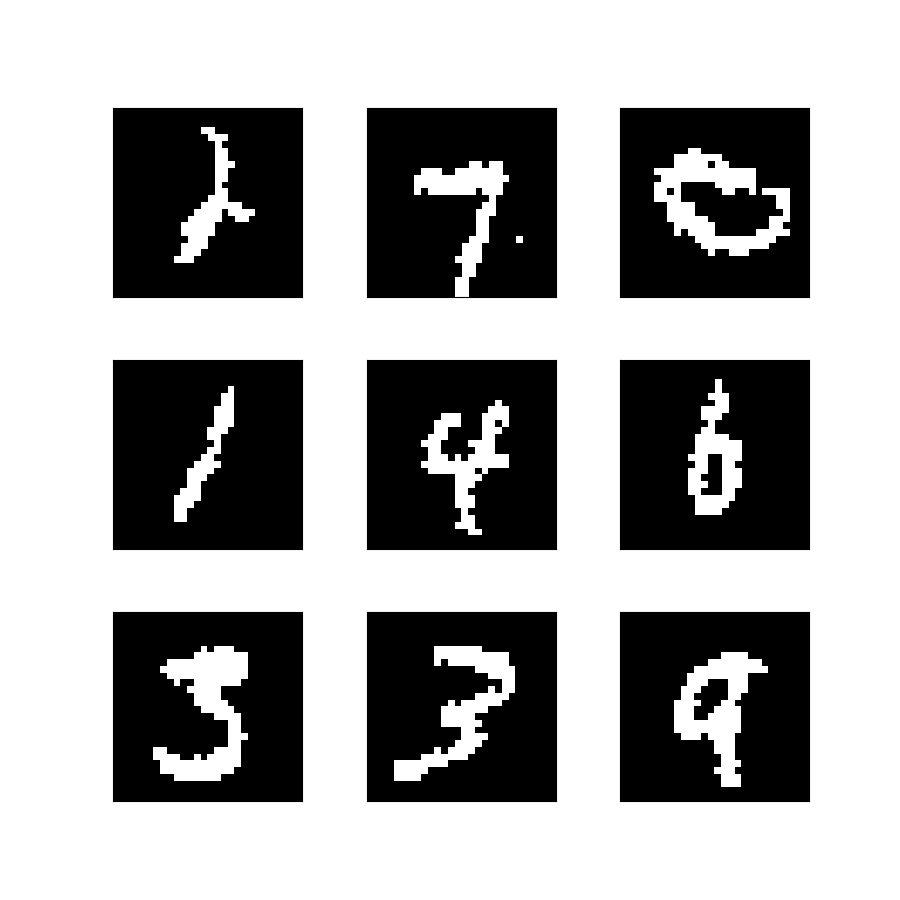</center>

**Question.** What the problem with histogram model for approximating binarized MNIST (or arbitrary images dataset)?

## Histogram for binarized Images

**Question**: How many parameters are needed to describe the probability distribution of a binarized image??

**Independent Pixel Encoding** - $N \times N$ assuming each pixel is encoded independently.

**Autoregressive Pixel Encoding** - $2^N - 1$ when using an autoregressive order, where each pixel depends on the previous ones.

## Bayes' theorem

$P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}$

$f(\theta|x) = \dfrac{f(x|\theta)g(\theta)}{\int f(x|\theta)g(\theta) d\theta}$

$\hat{\theta}_{ML} = \text{argmax}_\theta p(X|\theta)$

$\hat{\theta}_{MAP} = \text{argmax}_\theta p(\theta|X)$

## Recap

0. The main goal of generative modeling (when training a model) is to estimate the parameters of a chosen parametric distribution from a sample.
1. Reviewed what MLE (Maximum Likelihood Estimation) is, where it comes from, and how it is derived:
   - Write down the likelihood function and maximize it.
   - Use the method of Lagrange multipliers to handle constraints.
2. The idea of *reparameterization* to remove constraints — using SoftMax to avoid dealing with the Lagrangian.
3. Minimizing CrossEntropy is equivalent to maximizing MLE for categorical distributions.
4. Histogram model:
   - Default approach: "take the mean in the bin" = MLE estimation.
   - For a good approximation with a large $N$, a lot of samples are needed.
   - "Naive histogram" - all pixels are independent: requires $N \times N$ parameters.
   - Autoregressive order requires $2^N - 1$ parameters.
5. Bayes' theorem — recalled it and noted that MAP (Maximum A Posteriori) estimations also exist.